<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>
<hr/>
<font color="#800080" size=5>
Assignment 1 : Deep Autoregressive Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
<hr>
<font color='red'  size=4>
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @imoonamm
</font>
<br>
<hr>
</div></font>

**You should only change the blank sections, marked with TODO**

Pay attention to docstrings, as they may drastically help with your implementation.

You are advised to read all related papers and material, to help you better understand the design of each model.

# Question 1: WaveNet : A generative model for raw audio

WaveNet is a general purpose technology that has allowed us to unlock a range of new applications, from improving video calls on even the weakest connections to helping people regain their original voice after losing the ability to speak.

![Local GIF](unnamed.gif)

WaveNet models raw audio waveforms autoregressively:
$
p(x_{1:T}) = \prod_{t=1}^T p(x_t \mid x_{<t})
$
\
Instead of predicting spectrograms or using a vocoder, WaveNet predicts the next audio sample directly (often after µ-law companding and 8-bit/256-way quantization). This yields very natural sounding speech and music because the network learns the waveform structure end-to-end.

## 2. Core

### 2.1 Causal convolutions
A causal 1D convolution ensures predictions at time \(t\) don't depend on future samples:
- Achieved by padding only on the left (past).
- In practice, use `padding = dilation * (kernel_size - 1)` and then trim the rightmost elements (or use `Chomp1d` cropping).

### 2.2 Dilated convolutions
Dilations `[1, 2, 4, 8, ...]` in stacked layers let the receptive field grow exponentially with depth while keeping the number of parameters manageable. A stack of several cycles of dilations covers long temporal context (hundreds to thousands of samples).

### 2.3 Gated activation units
Each residual block uses a gated unit:
$
\text{z} = \tanh(W_f * x) \odot \sigma(W_g * x)
$
where `*` is dilated causal conv, `W_f` and `W_g` are convolution filters. The output splits to (1) residual connection and (2) skip connection that is added to final output.

### 2.4 Residual & skip connections
- Residual: `x_{l+1} = x_l + \text{residual\_out}` to ease training.
- Skip: every block outputs a skip tensor; all skip outputs are summed, then passed through post-processing (ReLU, Conv, softmax) to produce the final distribution over quantized samples.

### 2.5 Output quantization / softmax
Audio samples are often µ-law quantized to 256 values; WaveNet predicts a categorical distribution (`softmax(256)`) over those values for each time step. Continuous outputs are also possible (mixture of logistics / Gaussians) but discrete softmax is standard in the original paper.

### 2.6 Conditioning
- **Global conditioning**: a per-utterance vector (e.g., speaker id embedding) is added to layer activations.
- **Local conditioning**: low-rate features (e.g., mel spectrogram) are upsampled (transposed conv / nearest) and added at each time step.

---

## 3. Training & sampling

### Training
- Teacher forcing: at training time the network receives true previous samples and learns to predict the next sample with cross-entropy loss (if quantized).
- Batch size and optimization: use Adam, gradient clipping recommended for stability.
- Preprocess: µ-law companding + 256-level quantization is common.

### Sampling (inference)
- Autoregressive generation: sample one sample at a time and feed it back.
- Slow by default — many acceleration techniques exist (distillation → Parallel Wavenet, caching convolutions, WaveRNN, etc.).



**Reference:** [WaveNet: A Generative Model for Raw Audio* (van den Oord et al., DeepMind, 2016)](https://arxiv.org/abs/1609.03499)


In [245]:
!pip install torchaudio
# !pip install git+git://github.com/pytorch/audio
import torchaudio
import os


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import ModuleList
from IPython.display import Audio
from torch.autograd import Variable
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

ModuleNotFoundError: No module named 'torch'

### at first you must convert input into One Hot vector

5 Points


In [247]:
class OneHot(nn.Module):
    def __init__(self, MU):
        super(OneHot,self).__init__()
        self.MU = MU
        self.ones = None
        
    def forward(self, x):
        x = x.long()
        if (self.ones is None) or (self.ones.device != x.device) or (self.ones.size(0) != self.MU):
            self.ones = torch.eye(self.MU, device=x.device)
        flat = x.view(-1)
        oh = self.ones.index_select(0, flat)           # (batch*time, MU)
        return oh.view(*x.size(), self.MU)             # (batch, time, MU)
        
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.MU)

Before diving into the WaveNet model itself, it’s important to understand what kind of **data** we are modeling — **raw audio waveforms**.  
Neural networks can only process numbers, so we need to represent sound in a numerical form that captures its essential structure and variation.

---

## 1. Sampling Rate and Bit Depth

### Sound as a Signal
Sound in the real world is a **continuous analog waveform** — a pressure signal that varies smoothly over time.  
To process it digitally, we **sample** it: we take discrete measurements of the amplitude at equally spaced time intervals.

This process converts a continuous signal into a **time series of numbers**:
$
x = [x_1, x_2, \dots, x_T]
$
where each \(x_t\) represents the air pressure (or voltage) at time step \(t\).

---

### Sampling Rate
The **sampling rate** defines **how many times per second** we measure the amplitude of the signal.  
Typical values:
- CD quality audio: 44,100 Hz (samples per second)
- Speech datasets: 16,000 Hz or 22,050 Hz

A higher sampling rate means more detail, but also more data to process.  
WaveNet typically models 16 kHz or 22 kHz audio for speech generation tasks.

---

### Bit Depth
Each recorded sample must be represented by a finite number of bits.  
The **bit depth** determines the range and precision of these values:
- 8-bit → 256 possible levels  
- 16-bit → 65,536 levels  
- 24-bit → 16,777,216 levels  

The bit depth affects the **signal-to-noise ratio (SNR)** — higher bit depth means less quantization noise and a larger dynamic range:
$
\text{SNR} \approx 6.02 \times \text{bit depth} + 1.76\ \text{dB}
$

For example:
- 8-bit ≈ 49.9 dB SNR  
- 16-bit ≈ 98 dB SNR

---

## 2. From Audio to Time Series

After digitization, the audio signal becomes a **sequence of numbers over time**, also known as a **time series**.  
Each point depends on previous ones — this temporal dependency is what WaveNet models autoregressively:
$
p(x_{1:T}) = \prod_{t=1}^{T} p(x_t \mid x_{<t})
$

However, raw 16-bit audio contains **too many values** (65,536 possible amplitudes).  
Predicting the exact next value among that huge range is extremely hard for a neural network.

To simplify, we reduce this dynamic range to a smaller set — typically **256 levels** — using a technique called **µ-law companding**.

---

## 3. µ-law Quantization (Companding Transformation)

### Motivation
Human hearing follows the **Weber–Fechner law** — our perception of changes in loudness is **logarithmic**, not linear.  
That means we are more sensitive to small amplitude changes in quiet sounds than in loud ones.

µ-law companding exploits this property by **compressing the amplitude range logarithmically** —  
it allocates more resolution to small signals (quiet sounds) and less to large ones.

---

### µ-law Formula

$
f(x) = \text{sign}(x) \cdot \frac{\ln(1 + \mu |x|)}{\ln(1 + \mu)}, \quad -1 \le x \le 1
$

where:
- \(x\) = input waveform (normalized to [-1, 1])  
- \(\mu\) = companding constant (usually 255 for 8-bit quantization)

After applying µ-law, we map the range \([-1, 1]\) to discrete integer values \([0, 255]\).

---


## Defining Wavenet

20 Points

The following figure describes the overall architecture of WaveNet. Note that Transformers were non-existent in 2016!

![Wavenet Arch](WaveNet.png)

In [248]:
import torch.nn.functional as F

class Wavenet(nn.Module):
  def __init__(self,dilation_depth, n_blocks, n_dil_channels, n_residual_channels,n_skip_channels, n_category, kernel_size):
    super(Wavenet,self).__init__()
    self.dilation_depth = dilation_depth
    self.n_blocks = n_blocks
    self.n_dil_channels = n_dil_channels
    self.n_residual_channels = n_residual_channels
    self.n_skip_channels = n_skip_channels
    self.n_category = n_category
    self.kernel_size = kernel_size
    self.One_hot = OneHot(n_category)

    ###Building the model###

    ##creating first channels##
    self.causal = nn.Conv1d(n_category, n_residual_channels,
                            kernel_size, padding=kernel_size - 1)

    ###Creating wavenet blocks stacks###
    self.filter_convs = nn.ModuleList()
    self.gate_convs = nn.ModuleList()
    self.res_convs = nn.ModuleList()
    self.skip_convs = nn.ModuleList()
    for _ in range(n_blocks):
        for i in range(dilation_depth):
            dilation = 2 ** i
            pad = (kernel_size - 1) * dilation  # left padding for causality
            self.filter_convs.append(
                nn.Conv1d(n_residual_channels, n_dil_channels,
                          kernel_size, padding=pad, dilation=dilation))
            self.gate_convs.append(
                nn.Conv1d(n_residual_channels, n_dil_channels,
                          kernel_size, padding=pad, dilation=dilation))
            self.res_convs.append(
                nn.Conv1d(n_dil_channels, n_residual_channels, 1))
            self.skip_convs.append(
                nn.Conv1d(n_dil_channels, n_skip_channels, 1))
    ##post convoluions
    self.post = nn.Sequential(
      nn.ReLU(),
      nn.Conv1d(n_skip_channels, n_skip_channels, 1),
      nn.ReLU(),
      nn.Conv1d(n_skip_channels, n_category, 1)
    )

  def forward(self, x):
    # if x.dim() == 2:  # (B, T)
    #     x_oh = self.One_hot(x)              # (B, T, C)
    # else:  # already one-hot
    #     x_oh = x
    # x_oh = x_oh.transpose(1, 2)             # (B, C, T)
    # --- FIX STARTS HERE ---
    # Input x can be:
    # 1. LongTensor (B, T) of class indices -> needs one-hot encoding
    # 2. FloatTensor (B, C, T) from dataloader -> use as is
    if x.dim() == 2:
        x_oh = self.One_hot(x)      # -> (B, T, C)
        x_oh = x_oh.transpose(1, 2) # -> (B, C, T) for Conv1d
    else:
    # Assumes input is already one-hot and in (B, C, T) format
        x_oh = x
    # --- FIX ENDS HERE ---

    # Causal front-end (trim right to keep causality)
    x = self.causal(x_oh)
    if self.kernel_size > 1:
        x = x[:, :, :-(self.kernel_size - 1)]

    skip_connections = []
    for f, g, r, s in zip(self.filter_convs,
                          self.gate_convs,
                          self.res_convs,
                          self.skip_convs):
        tanh_out = torch.tanh(f(x))
        sigm_out = torch.sigmoid(g(x))

        # remove the extra right padding introduced by the dilated conv
        trim = (self.kernel_size - 1) * f.dilation[0]
        if trim > 0:
            tanh_out = tanh_out[:, :, :-trim]
            sigm_out = sigm_out[:, :, :-trim]

        z = tanh_out * sigm_out
        skip = s(z)
        skip_connections.append(skip)

        res = r(z)
        x = x[:, :, -res.size(2):]  # align with residual length
        x = x + res

    # Sum all skip connections and project to logits
    x = sum(skip_connections)
    x = self.post(x)                                # (B, n_category, T)
    x = x.transpose(1, 2)                           # (B, T, n_category)
    return x.squeeze(0) if x.size(0) == 1 else x
  ###Function to generate samples###
  def generate(self, input, num_samples=100):
    self.eval()
    if not torch.is_tensor(input):
        x = torch.tensor(input, dtype=torch.long)
    else:
        x = input.long()
    x = x.view(1, -1)  # (1, T)
    gen_list = x.squeeze(0).tolist()

    with torch.no_grad():
        for _ in range(num_samples):
            logits = self.forward(x)  # (T, n_category)
            probs = F.softmax(logits[-1], dim=-1)
            next_sample = torch.multinomial(probs, 1)  # sample from categorical
            gen_list.append(next_sample.item())
            x = torch.cat([x, next_sample.view(1, 1)], dim=1)

    return gen_list

Quantization of 16 bit audio

5 Points

In [249]:
def mulaw_quantize(x, qc):
    mu = qc - 1
    x_mu = torch.sign(x) * torch.log1p(mu * torch.abs(x)) / torch.log1p(mu)
    return x_mu

Inverse quantization

5 Points

In [250]:
def inv_mulaw_quantize(x_mu, quantization_channels=256, device = device):
    x_mu = x_mu.to(device)
    mu = quantization_channels - 1
    x = torch.sign(x_mu) * (torch.exp(torch.abs(x_mu) * torch.log1p(mu)) - 1.0) / mu
    return x

## Load Dataset
In this part you must load the audio_dataset.npz that exist in zip file of homework

10 Points

In [251]:
import os
import os.path
import math
import threading
import torch
import torch.utils.data
import numpy as np
import librosa as lr
import bisect


class WavenetDataset(torch.utils.data.Dataset):
    def __init__(self,
                 dataset_file,
                 item_length,
                 target_length,
                 file_location=None,
                 classes=256,
                 sampling_rate=16000,
                 mono=True,
                 normalize=False,
                 dtype=np.uint8,
                 train=True,
                 test_stride=100):

        #           |----receptive_field----|
        #                                 |--output_length--|
        # example:  | | | | | | | | | | | | | | | | | | | | |
        # target:                           | | | | | | | | | |

        self.dataset_file = dataset_file
        self._item_length = item_length
        self._test_stride = test_stride
        self.target_length = target_length
        self.classes = classes

        if not os.path.isfile(dataset_file):
            assert file_location is not None, "no location for dataset files specified"
            self.mono = mono
            self.normalize = normalize

            self.sampling_rate = sampling_rate
            self.dtype = dtype
            self.create_dataset(file_location, dataset_file)
        else:
            # Unknown parameters of the stored dataset
            # TODO Can these parameters be stored, too?
            self.mono = None
            self.normalize = None

            self.sampling_rate = None
            self.dtype = None

        self.data = np.load(self.dataset_file, mmap_mode='r')
        self.start_samples = [0]
        self._length = 0
        self.calculate_length()
        self.train = train
        print("one hot input")
        # assign every *test_stride*th item to the test set

    def calculate_length(self):
        start_samples = [0]
        for i in range(len(self.data.keys())):
            start_samples.append(start_samples[-1] + len(self.data[f'arr_{i}']))

        total = start_samples[-1]
        usable = max(0, total - self._item_length + 1)  # last valid start is total - item_length
        self._length = usable // self.target_length      # stride = target_length if that’s your intent
        self.start_samples = start_samples
        # start_samples = [0]
        # for i in range(len(self.data.keys())):
        #     start_samples.append(start_samples[-1] + len(self.data['arr_' + str(i)]))
        # available_length = start_samples[-1] - (self._item_length - (self.target_length - 1)) - 1
        # usable = max(0, self.start_samples[-1] - self._item_length + 1)
        # self._length = usable // self.target_length  # stride = target_length if you want that spacing
        # # self._length = math.floor(available_length / self.target_length)
        # self.start_samples = start_samples

    def set_item_length(self, l):
        self._item_length = l
        self.calculate_length()

    def __getitem__(self, idx):
        # TODO: Clarify sample_index calculation for train/test with test_stride
        if self._test_stride <= 0:
            sample_number = idx
        elif self.train:
            if self._test_stride == 1:
                raise IndexError("test_stride=1 moves every item to the test split.")
            block = idx // (self._test_stride - 1)
            offset = idx % (self._test_stride - 1)
            sample_number = block * self._test_stride + offset + 1
        else:
            sample_number = idx * self._test_stride
        sample_index = sample_number * self.target_length

        # TODO: Check file_index bounds; currently prints error, consider raising IndexError
        file_index = bisect.bisect_right(self.start_samples, sample_index) - 1
        if file_index < 0 or file_index >= len(self.start_samples) - 1:
            raise IndexError(f"Sample index {sample_index} is out of range.")

        file_key = f'arr_{file_index}'
        file_data = self.data[file_key]
        local_index = sample_index - self.start_samples[file_index]
        end_in_file = local_index + self._item_length

        if end_in_file <= len(file_data):
        # TODO: Avoid repeated np.load calls; cache self.data in __init__ instead
            window = file_data[local_index:end_in_file]

        else:
            # TODO: Optimize cross-file slicing; currently concatenates arrays which copies memory
            pieces = [file_data[local_index:]]
            remaining = self._item_length - len(pieces[0])
            next_file = file_index + 1
            while remaining > 0 and next_file < len(self.start_samples) - 1:
                chunk = self.data[f'arr_{next_file}']
                take = min(len(chunk), remaining)
                pieces.append(chunk[:take])
                remaining -= take
                next_file += 1
            if remaining > 0:
                raise IndexError(f"Not enough samples to build an item starting at {sample_index}.")
            window = np.concatenate(pieces, axis=0)
        

        # TODO: One-hot creation is memory heavy; consider returning integer indices and use nn.Embedding in model
        
        # fetch window with one more sample than the model input
        window = window.astype(np.int64, copy=False)
        x_tokens = window[:-1]                      # everything except the last sample
        y_tokens = window[1:]                       # everything except the first sample
        one_hot = np.zeros((self.classes, x_tokens.size), dtype=np.float32)
        time_idx = np.arange(x_tokens.size)
        one_hot[x_tokens, time_idx] = 1.0

        targets = torch.from_numpy(y_tokens[-self.target_length:]).long()

        # window = window.astype(np.int64, copy=False)
        # one_hot = np.zeros((self.classes, self._item_length), dtype=np.float32)
        # time_idx = np.arange(self._item_length)
        # one_hot[window, time_idx] = 1.0

        # target = torch.from_numpy(window[-self.target_length:]).long()
        one_hot = torch.from_numpy(one_hot)

        return one_hot, targets


    def __len__(self):
        # total number of usable start positions across all files
        test_length = math.floor(self._length / self._test_stride)
        if self.train:
            return self._length - test_length
        else:
            return test_length


def quantize_data(data, classes):
    encoded = mu_law_encoding(data, classes)
    quantized = ((encoded + 1.0) / 2.0 * (classes - 1) + 0.5).astype(np.int64)
    return quantized.astype(np.uint8)


def list_all_audio_files(location):
    audio_files = lr.util.find_files(location, ext=['wav', 'flac', 'ogg', 'mp3', 'aiff', 'm4a'])
    return sorted(audio_files)


def mu_law_encoding(data, mu):
    arr = np.clip(np.asarray(data, dtype=np.float32), -1.0, 1.0)
    return np.sign(arr) * np.log1p(mu * np.abs(arr)) / np.log1p(mu)


def mu_law_expansion(data, mu):
    arr = np.asarray(data, dtype=np.float32)
    return np.sign(arr) * (np.expm1(np.abs(arr) * np.log1p(mu)) / mu)

In [252]:
dilation_depth = 10
n_blocks = 2
n_dilation_channels = 24
n_residual_channels = 24
n_skip_channels = 128
n_category = 128
kernel_size = 2
model = Wavenet(dilation_depth,n_blocks,n_dilation_channels ,n_residual_channels,n_skip_channels,n_category,kernel_size)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')
model.to(device)

The model has 162,232 trainable parameters


Wavenet(
  (One_hot): OneHot(128)
  (causal): Conv1d(128, 24, kernel_size=(2,), stride=(1,), padding=(1,))
  (filter_convs): ModuleList(
    (0): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(1,))
    (1): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    (2): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
    (3): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(8,), dilation=(8,))
    (4): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(16,), dilation=(16,))
    (5): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(32,), dilation=(32,))
    (6): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(64,), dilation=(64,))
    (7): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(128,), dilation=(128,))
    (8): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(256,), dilation=(256,))
    (9): Conv1d(24, 24, kernel_size=(2,), stride=(1,), padding=(512,), dilation=(512,))
    (10): Conv1d(24,

### Define data generator

10 Points


In [253]:
import math

def data_generation(data, fr, seq_len_segment, mu, device=device):
    ###shape of data is [batch_size,seq_len]
    ### we want to randomly choose a starting position and then extract the seq_len_segment
    ### now the data is normalized for mu law encoding
    _ = fr  # placeholder to keep signature stable

    batch_size, total_len = data.shape
    if seq_len_segment < 2:
        raise ValueError("seq_len_segment must be at least 2 to form input/target pairs.")
    max_start = total_len - seq_len_segment
    if max_start < 0:
        raise ValueError("seq_len_segment is longer than available sequence length.")

    # Random start per item in batch
    start_positions = torch.randint(0, max_start + 1, (batch_size,), device=device)
    segments = torch.stack(
        [data[i, s : s + seq_len_segment] for i, s in enumerate(start_positions)],
        dim=0,
    )

    # µ-law companding + quantization to integer classes [0, mu]
    log_mu = math.log1p(mu)
    encoded = torch.sign(segments) * torch.log1p(mu * segments.abs()) / log_mu
    quantized = torch.clamp(((encoded + 1.0) * (mu / 2.0) + 0.5), 0, mu).long()

    # Teacher-forcing layout: predict t+1 from t
    x_tok = quantized[:, :-1]          # (B, T-1)
    y_tok = quantized[:, 1:]           # (B, T-1)

    # One-hot inputs for categorical softmax (B, classes, T-1)
    one_hot = torch.zeros(
        batch_size, seq_len_segment - 1, mu + 1, device=device, dtype=torch.float32
    )
    one_hot.scatter_(2, x_tok.unsqueeze(-1), 1.0)
    x_one_hot = one_hot.transpose(1, 2).contiguous()

    return x_one_hot, y_tok


### Visualize sample of data

5 Points

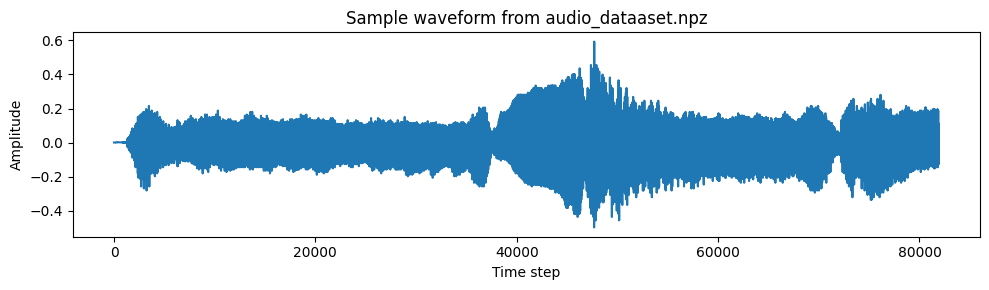

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
# import soundfile as sf

# Load first stored array; adjust key if needed
arr = np.load("audio_dataset.npz", mmap_mode="r")
signal = arr["arr_0"][30000:30000+20*4096]  # take a short window

# If already quantized ints, invert mu-law for plotting
mu = 255
if np.issubdtype(signal.dtype, np.integer):
    y = 2.0 * signal.astype(np.float32) / mu - 1.0
    signal = np.sign(y) * (np.expm1(np.abs(y) * np.log1p(mu)) / mu)

plt.figure(figsize=(10, 3))
plt.plot(signal)
plt.title("Sample waveform from audio_dataaset.npz")
plt.xlabel("Time step")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

Audio(signal, rate=16000)

### Optimizer and Loss Function

5 Points

In [255]:
import torch.nn as nn
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()  # targets are class indices in [0, mu]
# optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)


c:\Users\Password Please\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

10 Points

In [ ]:
def train_wavenet(model,
                  dataloader,
                  epochs,
                  optimizer,
                  device,
                  print_every=50):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []

    for epoch in range(1, epochs + 1):
        running = 0.0
        count = 0
        
        for step, (x, y) in enumerate(dataloader, 1):
            x = x.to(device)  # (B, C, T) one-hot encoded
            y = y.to(device)  # (B, target_length) target tokens
            
            optimizer.zero_grad()
            logits = model(x)  # (B, T_out, C)
            
            # The model outputs predictions for the last target_length positions
            # Align with targets properly
            T_out = logits.size(1)
            T_target = y.size(1)
            
            # Take the last T_target predictions
            if T_out >= T_target:
                logits = logits[:, -T_target:, :]
            else:
                # If model output is shorter, pad targets from the end
                y = y[:, -T_out:]
            
            B, T, C = logits.shape
            loss = criterion(
                logits.reshape(B * T, C),
                y.reshape(B * T)
            )
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Add gradient clipping
            optimizer.step()
            
            running += loss.item()
            count += 1

            if step % print_every == 0:
                avg = running / count
                print(f"Epoch {epoch} Step {step}: loss {avg:.4f}")
                running = 0.0
                count = 0

        if count > 0:
            epoch_loss = running / count
            train_losses.append(epoch_loss)
            print(f"Epoch {epoch} done. Avg Loss: {epoch_loss:.4f}")
            
        scheduler.step(epoch_loss)

    return train_losses


## Plot losses

5 Points

In [257]:
import matplotlib.pyplot as plt

def plot_losses(trainLoss, Epochs):
    plt.figure(figsize=(6,4))
    plt.plot(range(1, Epochs + 1), trainLoss, marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Train Loss")
    plt.title("WaveNet Training Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Save the model

5 Points


In [258]:
def save_model(model, path="wavenet.pt"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

## Generate Audio using trained model

5 Points

In [259]:
def generate_audio(model,
                   seed,
                   samples,
                   device,
                   receptive_field,
                   classes=256,
                   mu=255):
    model.eval()
    seed = seed.to(device)
    generated = seed.clone()

    with torch.no_grad():
        for _ in range(samples):
            # x = torch.zeros(1, generated.numel(), classes, device=device)
            # idx = torch.arange(generated.numel(), device=device)
            # x[0, idx, generated] = 1.0  
            # --- FIX & OPTIMIZATION ---
            # 1. Take only the last `receptive_field` samples as input context.
            #    This is much more efficient than processing the whole sequence.
            context = generated[-receptive_field:]
            
            # 2. Correctly one-hot encode and shape the input tensor.
            #    context shape: (receptive_field,)
            #    F.one_hot -> (receptive_field, classes)
            #    .unsqueeze(0) -> (1, receptive_field, classes)
            #    .transpose(1, 2) -> (1, classes, receptive_field) -> This is the correct shape!
            x = F.one_hot(context, num_classes=classes).float().unsqueeze(0).transpose(1, 2)
            
            # --- END FIX ---


            logits = model(x).squeeze(0)   # (T, classes)
            next_logits = logits[-1]       # final timestep, shape (classes,)
            probs = torch.softmax(next_logits, dim=-1)
            next_token = torch.multinomial(probs, 1)

            generated = torch.cat([generated, next_token], dim=0)

    return generated.cpu()

def inv_mulaw_int_to_float(x_int, mu=255):
    """x_int: Long/Int tensor in [0, mu]; returns float tensor in [-1, 1]."""
    y = 2.0 * x_int.float() / mu - 1.0
    return torch.sign(y) * (torch.expm1(torch.abs(y) * math.log1p(mu)) / mu)


In [ ]:
def generate_audio_optimized(model, seed, num_samples, device, receptive_field, temperature=1.0):
    model.eval()
    with torch.no_grad():
        # Start with seed
        current_sequence = seed.clone().to(device)
        generated = []
        
        for i in range(num_samples):
            # Only use the last receptive_field samples as context
            if len(current_sequence) > receptive_field:
                context = current_sequence[-receptive_field:]
            else:
                context = current_sequence
            
            # One-hot encode and shape for model
            x = F.one_hot(context, num_classes=256).float().unsqueeze(0).transpose(1, 2)
            
            # Get predictions
            logits = model(x)[0, -1]  # Last timestep
            logits = logits / temperature
            
            # Sample next token
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, 1)
            
            generated.append(next_token.item())
            current_sequence = torch.cat([current_sequence, next_token.cpu()])
            
            if (i + 1) % 1000 == 0:
                print(f"Generated {i+1}/{num_samples} samples")
    
    return torch.tensor(generated)

In [ ]:
def calculate_receptive_field(dilation_depth, n_blocks, kernel_size):
    rf = 1
    for block in range(n_blocks):
        for layer in range(dilation_depth):
            rf += (kernel_size - 1) * (2 ** layer)
    return rf

one hot input
Input shape: torch.Size([16, 256, 6143])
Target shape: torch.Size([16, 4096])
Target range: [19, 234]
Epoch 1 Step 50: loss 5.1996
Epoch 1 Step 100: loss 4.5446
Epoch 1 done. Avg Loss: 3.8077
Epoch 2 Step 50: loss 3.6435
Epoch 2 Step 100: loss 3.5492
Epoch 2 done. Avg Loss: 3.4741
Epoch 3 Step 50: loss 3.4331
Epoch 3 Step 100: loss 3.4238
Epoch 3 done. Avg Loss: 3.3993
Epoch 4 Step 50: loss 3.3610
Epoch 4 Step 100: loss 3.3251
Epoch 4 done. Avg Loss: 3.2843
Epoch 5 Step 50: loss 3.3100
Epoch 5 Step 100: loss 3.2956
Epoch 5 done. Avg Loss: 3.2479
Epoch 6 Step 50: loss 3.2602
Epoch 6 Step 100: loss 3.2657
Epoch 6 done. Avg Loss: 3.2608
Epoch 7 Step 50: loss 3.2171
Epoch 7 Step 100: loss 3.2377
Epoch 7 done. Avg Loss: 3.1936
Epoch 8 Step 50: loss 3.2033
Epoch 8 Step 100: loss 3.2052
Epoch 8 done. Avg Loss: 3.1918
Epoch 9 Step 50: loss 3.1966
Epoch 9 Step 100: loss 3.1694
Epoch 9 done. Avg Loss: 3.1797
Epoch 10 Step 50: loss 3.1517
Epoch 10 Step 100: loss 3.1739
Epoch 10 done

ValueError: x and y must have same first dimension, but have shapes (20,) and (60,)

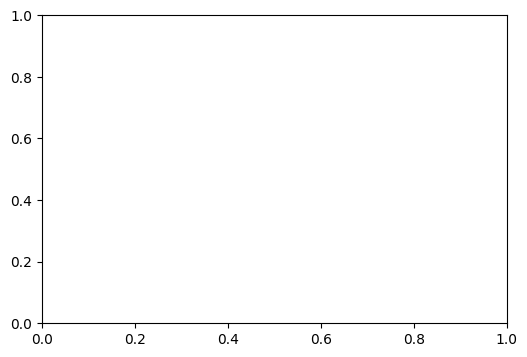

In [ ]:
# Hyperparams
epochs = 20
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dilation_depth = 10
n_blocks = 4
n_dilation_channels = 128
n_residual_channels = 128  
n_skip_channels = 256
n_category = 256
kernel_size = 2

receptive_field = calculate_receptive_field(dilation_depth, n_blocks, kernel_size)
target_length = 2048
item_length = receptive_field + target_length

model = Wavenet(dilation_depth, n_blocks, n_dilation_channels,
                     n_residual_channels, n_skip_channels, n_category, kernel_size)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, verbose=True
)

# Dataloader from your WavenetDataset
train_ds = WavenetDataset("audio_dataset.npz",
                          item_length=receptive_field + target_length,
                          target_length=target_length,
                          train=True)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)

# Check what the dataset returns
x_sample, y_sample = next(iter(train_loader))
print(f"Input shape: {x_sample.shape}")  # Should be (B, C=256, T)
print(f"Target shape: {y_sample.shape}")  # Should be (B, target_length)
print(f"Target range: [{y_sample.min()}, {y_sample.max()}]")  # Should be [0, 255]

# Train
train_losses = train_wavenet(model, train_loader, epochs, optimizer, device)

# Plot
plot_losses(train_losses, epochs)

# Save
save_model(model, "wavenet.pt")

In [ ]:
# Generate a sample
# use first window of dataset as seed
seed_one_hot, seed_targets = next(iter(train_loader))
seed_indices = seed_targets[0]  # last target_length tokens
generated_tokens = generate_audio(model,
                                  seed_indices,  # or a longer seed tensor
                                  samples=16000*2,  # generate 1s at 16kHz
                                  device=device, receptive_field=receptive_field)

# Convert to waveform (float in [-1,1])
waveform = inv_mulaw_int_to_float(generated_tokens, mu=255).numpy()

# Optional: write to WAV
import soundfile as sf
sf.write("generated.wav", waveform, samplerate=16000)


In [262]:
Audio(waveform, rate=16000)

In [263]:
# Fix 1: Calculate correct receptive field
def calculate_receptive_field(dilation_depth, n_blocks, kernel_size):
    rf_per_block = sum((kernel_size - 1) * (2 ** i) for i in range(dilation_depth))
    total_rf = n_blocks * rf_per_block + 1
    return total_rf

dilation_depth = 10
n_blocks = 2
kernel_size = 2

receptive_field = calculate_receptive_field(dilation_depth, n_blocks, kernel_size)
print(f"Actual receptive field: {receptive_field}")  # Should be 2047

target_length = 1024  # Reduce this for faster training

# Fix 2: Corrected WaveNet forward pass
class WavenetFixed(nn.Module):
    def __init__(self, dilation_depth, n_blocks, n_dil_channels, 
                 n_residual_channels, n_skip_channels, n_category, kernel_size):
        super(WavenetFixed, self).__init__()
        self.dilation_depth = dilation_depth
        self.n_blocks = n_blocks
        self.n_dil_channels = n_dil_channels
        self.n_residual_channels = n_residual_channels
        self.n_skip_channels = n_skip_channels
        self.n_category = n_category
        self.kernel_size = kernel_size
        self.One_hot = OneHot(n_category)

        # Causal convolution - NO padding here, we'll handle it manually
        self.causal = nn.Conv1d(n_category, n_residual_channels, kernel_size)

        # Dilated convolution stacks
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.res_convs = nn.ModuleList()
        self.skip_convs = nn.ModuleList()
        
        for _ in range(n_blocks):
            for i in range(dilation_depth):
                dilation = 2 ** i
                # Use padding=0, we'll handle causal padding manually
                self.filter_convs.append(
                    nn.Conv1d(n_residual_channels, n_dil_channels,
                              kernel_size, dilation=dilation, padding=0))
                self.gate_convs.append(
                    nn.Conv1d(n_residual_channels, n_dil_channels,
                              kernel_size, dilation=dilation, padding=0))
                self.res_convs.append(
                    nn.Conv1d(n_dil_channels, n_residual_channels, 1))
                self.skip_convs.append(
                    nn.Conv1d(n_dil_channels, n_skip_channels, 1))

        # Post-processing
        self.post = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(n_skip_channels, n_skip_channels, 1),
            nn.ReLU(),
            nn.Conv1d(n_skip_channels, n_category, 1)
        )

    def forward(self, x):
        # Handle input format
        if x.dim() == 2:
            x_oh = self.One_hot(x)
            x_oh = x_oh.transpose(1, 2)
        else:
            x_oh = x
        
        # Apply causal front-end with manual left-padding
        x = F.pad(x_oh, (self.kernel_size - 1, 0))  # Left pad only
        x = self.causal(x)  # Now output length = input length

        skip_connections = []
        
        for f, g, r, s in zip(self.filter_convs, self.gate_convs,
                              self.res_convs, self.skip_convs):
            # Manual causal padding
            pad_amount = (self.kernel_size - 1) * f.dilation[0]
            x_padded = F.pad(x, (pad_amount, 0))  # Left pad only
            
            # Apply gated activation
            tanh_out = torch.tanh(f(x_padded))
            sigm_out = torch.sigmoid(g(x_padded))
            z = tanh_out * sigm_out
            
            # Skip connection
            skip = s(z)
            skip_connections.append(skip)
            
            # Residual connection
            res = r(z)
            x = x + res  # Now they should have the same length!

        # Sum skip connections and generate output
        x = sum(skip_connections)
        x = self.post(x)  # (B, n_category, T)
        x = x.transpose(1, 2)  # (B, T, n_category)
        
        return x

# Fix 3: Corrected training loop
def train_wavenet_fixed(model, dataloader, epochs, optimizer, device, print_every=50):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    train_losses = []

    for epoch in range(1, epochs + 1):
        epoch_loss = 0.0
        num_batches = 0
        
        for step, (x, y) in enumerate(dataloader, 1):
            x = x.to(device)  # (B, C, T)
            y = y.to(device)  # (B, target_length)
            
            optimizer.zero_grad()
            logits = model(x)  # (B, T_out, C)
            
            # Only use the last target_length predictions
            logits = logits[:, -y.size(1):, :]
            
            B, T, C = logits.shape
            
            # Reshape for loss calculation
            loss = criterion(
                logits.contiguous().view(B * T, C),
                y.contiguous().view(B * T)
            )
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1

            if step % print_every == 0:
                avg_loss = epoch_loss / num_batches
                print(f"Epoch {epoch} Step {step}: loss {avg_loss:.4f}")

        avg_epoch_loss = epoch_loss / num_batches
        train_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch} complete. Average loss: {avg_epoch_loss:.4f}\n")

    return train_losses

# Fix 4: Use correct hyperparameters
n_category = 256
n_dilation_channels = 32
n_residual_channels = 32
n_skip_channels = 256

model = WavenetFixed(dilation_depth, n_blocks, n_dilation_channels,
                     n_residual_channels, n_skip_channels, n_category, kernel_size)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)

# Create dataset with CORRECT receptive field
train_ds = WavenetDataset(
    "audio_dataset.npz",
    item_length=receptive_field + target_length,  # Remove the +1
    target_length=target_length,
    train=True
)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=8, shuffle=True, drop_last=True, num_workers=0
)

# Train
print(f"Starting training with receptive field={receptive_field}, target_length={target_length}")
train_losses = train_wavenet_fixed(model, train_loader, epochs=20, optimizer=optimizer, device=device)


Actual receptive field: 2047
one hot input
Starting training with receptive field=2047, target_length=1024
Epoch 1 Step 50: loss 5.3393
Epoch 1 Step 100: loss 5.2436
Epoch 1 Step 150: loss 5.2071
Epoch 1 Step 200: loss 5.1666
Epoch 1 Step 250: loss 5.0955
Epoch 1 Step 300: loss 4.9779
Epoch 1 Step 350: loss 4.8508
Epoch 1 Step 400: loss 4.7297
Epoch 1 Step 450: loss 4.6246
Epoch 1 Step 500: loss 4.5380
Epoch 1 Step 550: loss 4.4674
Epoch 1 Step 600: loss 4.3996
Epoch 1 Step 650: loss 4.3441
Epoch 1 Step 700: loss 4.2928
Epoch 1 Step 750: loss 4.2473
Epoch 1 Step 800: loss 4.2044
Epoch 1 Step 850: loss 4.1683
Epoch 1 Step 900: loss 4.1348
Epoch 1 Step 950: loss 4.1029
Epoch 1 Step 1000: loss 4.0753
Epoch 1 Step 1050: loss 4.0489
Epoch 1 Step 1100: loss 4.0250
Epoch 1 Step 1150: loss 4.0031
Epoch 1 complete. Average loss: 3.9994

Epoch 2 Step 50: loss 3.4918
Epoch 2 Step 100: loss 3.4990
Epoch 2 Step 150: loss 3.4881
Epoch 2 Step 200: loss 3.4805
Epoch 2 Step 250: loss 3.4710
Epoch 2 Ste

In [264]:
# Generate a sample
# use first window of dataset as seed
seed_one_hot, seed_targets = next(iter(train_loader))
seed_indices = seed_targets[0]  # last target_length tokens
generated_tokens = generate_audio(model,
                                  seed_indices,  # or a longer seed tensor
                                  samples=16000,  # generate 1s at 16kHz
                                  device=device, receptive_field=receptive_field)

# Convert to waveform (float in [-1,1])
waveform = inv_mulaw_int_to_float(generated_tokens, mu=255).numpy()

# Optional: write to WAV
import soundfile as sf
sf.write("generated.wav", waveform, samplerate=16000)


In [265]:
Audio(waveform, rate=16000)

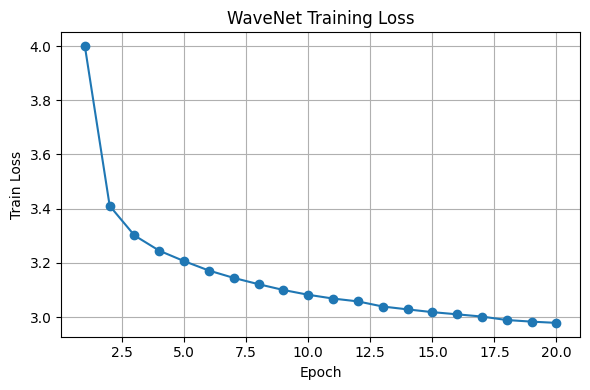

Model saved to wavenet.pt


In [266]:
# Plot
plot_losses(train_losses, epochs)

# Save
save_model(model, "wavenet.pt")